In [1]:
import numpy as np
import matplotlib.pylab as plt 
%matplotlib inline
# from util import *

import sys
sys.path.insert(1, "../")

import networkx as nx
import SpringRank_tools as sr
import tools as tl
from scipy.optimize import brentq

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

# Reply Kernel

In [2]:
# Reply Kernel
def p_reply(sender, replier, scale, shift):
    logodds = np.log(scale/(1-scale))
    score = sender - replier + shift
    return 1/(1 + np.exp(-logodds * score))

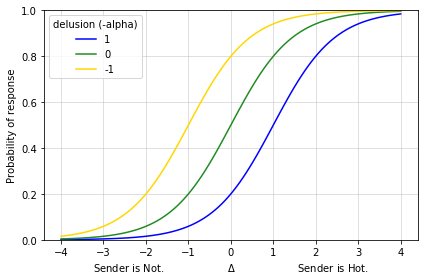

In [3]:
replier = 0
scale = 0.8
sender = np.linspace(-4,4,100)

fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(sender,p_reply(sender, replier, scale, -1),
        c='Blue',label="1")
ax.plot(sender,p_reply(sender, replier, scale, 0),
        c='ForestGreen',label="0")
ax.plot(sender,p_reply(sender, replier, scale, 1),
        c='Gold',label="-1")
ax.set_ylim([0,1])
plt.tight_layout()
ax.grid(alpha=0.5)
ax.set_xlabel('Sender is Not.                    $\Delta$                    Sender is Hot.')
ax.set_ylabel('Probability of response')
# finalize(ax)
ax.legend(title="delusion (-alpha)")
plt.tight_layout()

# plt.savefig('figures/reply.pdf')

# First Message Kernel

In [4]:
# First Message Kernel
def kern(sender,receiver,scale,shift):
    logodds = np.log(scale/(1-scale))
    score = sender - receiver + shift
    return 1/(1 + np.exp(-logodds * score))

def p_first(sender, receiver, Lscale, Lshift, Rscale, Rshift):
    a = kern(sender,receiver,Lscale,Lshift)
    b = kern(sender,receiver,Rscale,Rshift)
    return a*b

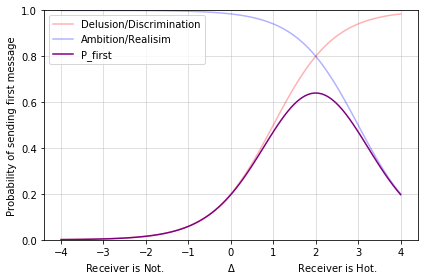

In [5]:
sender = 0
Lscale = 0.9
Lshift = 1
Rshift = 1
Rscale = 1-Lscale
receiver = np.linspace(-4,4,100)

fig,ax = plt.subplots(1,1,figsize=(6,4))
# slopes
discrimination = 0.8
realism = 0.8
# shifts
delusion = 1
ambition = 3

# delusion/discrimination
ax.plot(receiver,kern(sender, receiver, 
                         scale=1-discrimination,
                         shift=delusion),
        c='Red', alpha=0.3, label="Delusion/Discrimination")
# ambition/realism
ax.plot(receiver,kern(sender, receiver, 
                         scale=realism,
                         shift=ambition),
        c='Blue',alpha=0.3, label="Ambition/Realisim")
ax.plot(receiver,p_first(sender, receiver, 
                         Lscale=1-discrimination,
                         Lshift=delusion,
                         Rscale=realism,
                         Rshift=ambition),
        c='Purple', label="P_first")

ax.set_ylim([0,1])
plt.tight_layout()
ax.grid(alpha=0.5)
ax.set_xlabel('Receiver is Not.                    $\Delta$                    Receiver is Hot.')
ax.set_ylabel('Probability of sending first message')
# finalize(ax)
ax.legend()
plt.tight_layout()
# plt.savefig('figures/first.pdf')

# First Simulation

So what should a simulation look like? Well, we have the probability that first messages get sent. And then we have the probability of reply. So we could just generate a bunch of first messages. And then generate a bunch of replies. 

But how many people should we have and what should their ranks be? idk. Let's imagine that we have 500 men and 500 women to start. Let's draw all of their ranks to be between 1 and 10. Let's present every woman to every man and generate first messages. Let's then compute replies!

In [6]:
# N total (divisible by 2)
N = 1000
N_men = N // 2
N_women = N // 2

# Generate ranks
s_men = np.random.uniform(low=1,high=10,size=N_men)
s_women = np.random.uniform(low=1,high=10,size=N_women)

# slopes
discrimination = 0.8
realism = 0.8
# shifts
delusion = 1
ambition = 3

In [7]:
msg_first = np.zeros([N_men,N_women])
list_first = []
for idxman,man in enumerate(s_men):
    for idxwoman,woman in enumerate(s_women):
        # is there a message?
        pr = p_first(man,woman,
                         Lscale=1-discrimination,
                         Lshift=delusion,
                         Rscale=realism,
                         Rshift=ambition)
        msg_first[idxman,idxwoman] = np.random.binomial(1, pr)
        if msg_first[idxman,idxwoman]==1:
            list_first.append([idxman,idxwoman])

In [8]:
print("There were {:.0f} first messages sent. ({:.1f}%)".format(np.sum(msg_first),100*np.sum(msg_first)/(N_men*N_women)))

There were 44276 first messages sent. (17.7%)


In [9]:
msg_reply = np.zeros([N_men,N_women])
list_reply = []
for first in list_first:
    # is there a reply?
    idxman = first[0]
    idxwoman = first[1]
    pr = p_reply(s_men[idxman],s_women[idxwoman],
                scale=discrimination,
                shift=-delusion)
    msg_reply[idxman,idxwoman] = np.random.binomial(1, pr)
    if msg_reply[idxman,idxwoman]==1:
        list_reply.append([idxman,idxwoman])

In [10]:
print("There were {:.0f} replies. ({:.1f}%)".format(np.sum(msg_reply),100*np.sum(msg_reply)/np.sum(msg_first)))

There were 3005 replies. (6.8%)


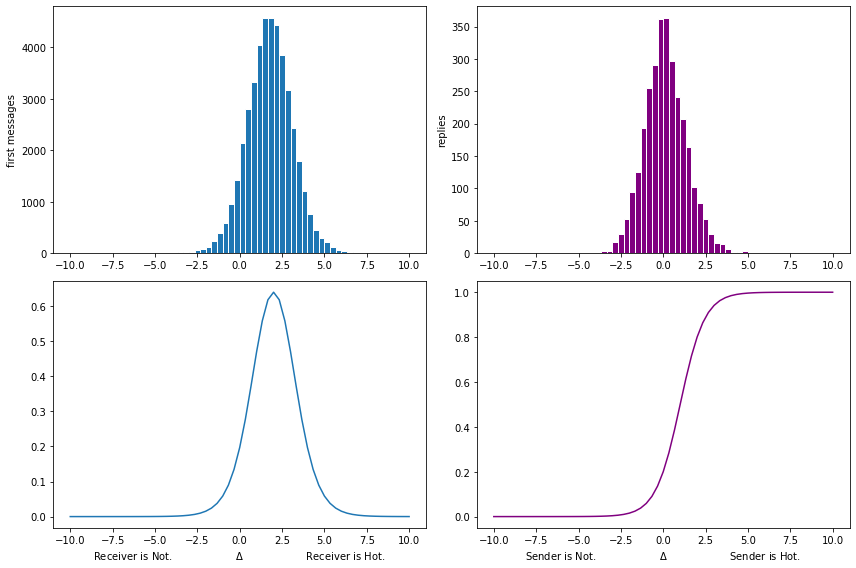

In [11]:
# Make some plots
# First Messages
gap = []
for first in list_first:
    gap.append(s_women[first[1]]-s_men[first[0]])
fig,axs = plt.subplots(2,2,figsize=(2*6,2*4))
binz = np.linspace(-10,10,61)
axs[0,0].hist(gap,bins=binz,
       edgecolor='white')
axs[0,0].set_ylabel("first messages")
axs[1,0].plot(binz,p_first(0,binz,
        Lscale=1-discrimination,
        Lshift=delusion,
        Rscale=realism,
        Rshift=ambition)) 
axs[1,0].set_xlabel('Receiver is Not.                    $\Delta$                    Receiver is Hot.')

# Replies
gap = []
for reply in list_reply:
    gap.append(s_men[reply[0]]-s_women[reply[1]])
binz = np.linspace(-10,10,61)
axs[0,1].hist(gap,bins=binz,
       edgecolor='white',
            facecolor="purple")
axs[0,1].set_ylabel("replies")
axs[1,1].plot(binz,p_reply(binz,0,
                       scale=discrimination,
                       shift=-delusion),
            color="purple")
axs[1,1].set_xlabel('Sender is Not.                    $\Delta$                    Sender is Hot.')

# for ax in axs.flatten():
#     finalize(ax)
plt.tight_layout()
# plt.savefig('figures/confirmation.pdf')

# Analysis of Simulation: Can we extract hierarchy?

We're going to need code that takes messaging patterns and then creates a directed network. 

In [12]:
# All the data that we need are in:
# list_first[idxman,idxwoman]
# list_reply[idxman,idxwoman]

# Prep
first = np.array(list_first)
reply = np.array(list_reply)

# Get the list of women who replied to anyone. This basically ends up being everyone...
arbiters = np.unique(reply[:,1])

# For each woman, determine who did not get a reply, and who did get a reply
ibeatj = np.zeros([N_men,N_men],dtype=int)
for a in arbiters:
    gotReply = reply[reply[:,1]==a][:,0]
    sentFirst = first[first[:,1]==a][:,0]
    gotSilence = np.setdiff1d(sentFirst,gotReply)
    for winner in gotReply:
        for loser in gotSilence:
            ibeatj[winner,loser] += 1
A = ibeatj

In [13]:
rank=sr.SpringRank(A, alpha=0)
rank=tl.shift_ranks(rank)

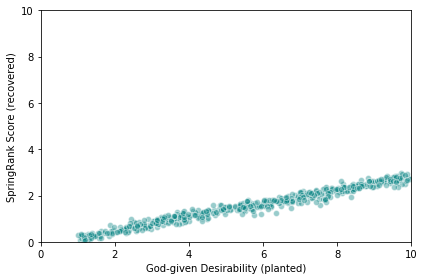

In [16]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(s_men,rank,
           alpha=0.4,
           color='teal',
           edgecolor='white',
           label='{:.0f} first msgs, {:.0f} replies'.format(np.sum(msg_first),np.sum(msg_reply))
          )
ax.set_xlabel('God-given Desirability (planted)')
ax.set_ylabel('SpringRank Score (recovered)')
ax.set_ylim([0,10])
ax.set_xlim([0,10])
# finalize(ax)
plt.tight_layout()
# plt.savefig('figures/expt1_springrank.pdf')

# Finding the scaling of the hierarchy from the data

The original data were drawn on a scale from 1 to 10. SpringRank scores are arbitrarily scaled. But perhaps we can discover the scaling from the data themselves.

SpringRank says:

$$P_{i \to j} = \frac{1}{1+\exp(-2 \beta (s_i - s_j))}$$

We said in our work that we wanted this to be 0.8 when $s_i - s_j=1$.  So let's imagine just rescaling the ranks of SpringRank by $s \to k \times s$. Then, what should $k$ be?

$$0.8 = \frac{1}{1+\exp(-2 \beta (1)/k)}$$

and then some algebra to get

$$k = \frac{\text{logodds}(0.8)}{2\beta}$$

Where $\beta$ is the value of $\beta$ that we get from finding the optimal (best-fit) inverse temperature in SpringRank. It's all just there in the paper.

In [19]:
scaled_ranks = tl.adjust_ranks(rank, A, least_rank=1)

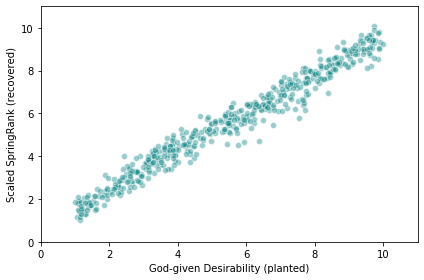

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(s_men,scaled_ranks,
           alpha=0.4,
           color='teal',
           edgecolor='white',
           label='{:.0f} first msgs, {:.0f} replies'.format(np.sum(msg_first),np.sum(msg_reply))
          )
ax.set_xlabel('God-given Desirability (planted)')
ax.set_ylabel('Scaled SpringRank (recovered)')
ax.set_ylim([0,11])
ax.set_xlim([0,11])
# finalize(ax)
plt.tight_layout()
# plt.savefig('figures/expt1_springrankscaled.pdf')

In [22]:
np.ptp(scaled_ranks)

9.069365554636247

In [23]:
np.ptp(s_men)

8.970059218450443